<a href="https://colab.research.google.com/github/sriram1105-m/CE888---Data-Science-and-Decision-Making/blob/main/Project1/Wildfire_inception_swish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
import PIL
from PIL import Image

import keras

In [ ]:
image_train = keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/OneDrive_1_1-27-2021.zip (Unzipped Files)/Training.zip (Unzipped Files)/Training',
                                                          labels  = "inferred", label_mode = "int", color_mode = "rgb")

image_test = keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/OneDrive_1_1-27-2021.zip (Unzipped Files)/Test.zip (Unzipped Files)/Test',
                                                          labels  = "inferred", label_mode = "int", color_mode = "rgb")

Found 39375 files belonging to 2 classes.
Found 8617 files belonging to 2 classes.


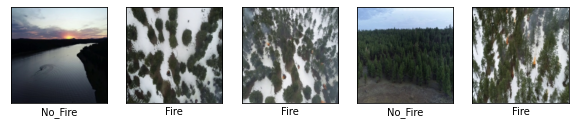

In [ ]:
# Get the list of class names
# The encoded number is the index of the class_names list
class_name = image_train.class_names

fig,ax = plt.subplots(1,5,figsize=(10,10))
ax = ax.flat

# Get the first batch of dataset, it has batch_size(64) images and corresponding labels
# Let's show the first 25 images
for images,labels in image_train.take(1):
    for i in range(5):
        ax[i].imshow(images[i].numpy().astype('uint8'))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlabel(class_name[labels[i]])
plt.show()

In [ ]:
# Identifying the labels
labels = os.listdir('/content/drive/MyDrive/OneDrive_1_1-27-2021.zip (Unzipped Files)/Training.zip (Unzipped Files)/Training')
print(labels)

['No_Fire', 'Fire']


In [ ]:
# Importing the required libraries
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
# Data Preprocessing
#Image Data Generator
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,   # Stretches and slant the image to a particular angle
                                   rotation_range = 20, # randomly rotates the image so that the model become inavariant to object orientation
                                   zoom_range = 0.2,    #randomly zoom-in or zoom-out the image
                                   brightness_range = [0.8, 1.2], #range changes the brightness of the image
                                   horizontal_flip = True) #randomly flips the image horizontally

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/OneDrive_1_1-27-2021.zip (Unzipped Files)/Training.zip (Unzipped Files)/Training',
                                                  target_size = (224, 224),
                                                  batch_size = 32,
                                                  class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/OneDrive_1_1-27-2021.zip (Unzipped Files)/Test.zip (Unzipped Files)/Test',
                                             target_size = (224, 224),
                                             batch_size = 32,
                                             class_mode = 'binary')

Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


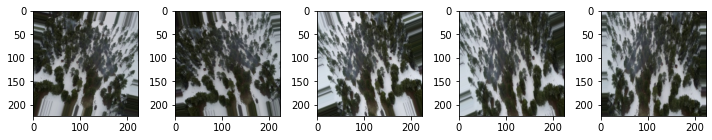

In [ ]:
# Visualizing images after augmenting
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [training_set[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
# Finding the class Index
training_set.class_indices

{'Fire': 0, 'No_Fire': 1}

In [ ]:
# Using ResNet model
inception = InceptionV3(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False) #using input shape the size of the images were reshaped to 224x224

for layer in inception.layers:
  layer.trainable = False

inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
#Importing required libraries
from keras.layers import Dropout
from keras import models, regularizers, layers, optimizers, losses, metrics

from keras.layers import GlobalAveragePooling2D, Concatenate

In [ ]:
# Modelling 
add_model = Sequential()
add_model.add(inception)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dense(256, activation ='swish'))
add_model.add(Dropout(0.5))
add_model.add(Dense(1, 
                    activation='sigmoid'))

In [ ]:
add_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 22,327,585
Trainable params: 524,801
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
callback = keras.callbacks.EarlyStopping(
    monitor = 'accuracy',
    min_delta = 0,
    patience = 3,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = False
)

In [ ]:
# Compiling the model
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

In [ ]:
print(add_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 22,327,585
Trainable params: 524,801
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [ ]:
#Fitting the model
history = model.fit(training_set, steps_per_epoch = 10, epochs = 100, 
                              callbacks = [callback])

Epoch 1/100
10/10 [==============================] - 116s 12s/step - loss: 0.3699 - accuracy: 0.9531
Epoch 2/100


KeyboardInterrupt: ignored

In [ ]:
# Testing the model with a sample image 

import numpy as np
from keras.preprocessing import image

test_image = image.load_img('/content/drive/MyDrive/OneDrive_1_1-27-2021.zip (Unzipped Files)/Test.zip (Unzipped Files)/Test/Fire/resized_test_fire_frame1318.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = swish.predict(test_image)
training_set.class_indices
if result[0][0] == 0:
  print('Fire')
else:
  print('No Fire')